# <center> Fisher Information Matrix Approach for Optimizing Experimental Design of Pharmacokinetic Studies <center>

## <center> Jaron Thompson <center>

### <center> Introduction: <center> 
    
Physiologically based pharmacokinetic (PBPK) modeling aims to predict the absorption, distribution, metabolism, and excretion (ADME) of a drug based on a physiologically relevant mathematical model.  PBPK models describe separate organs as a system of connected compartments. PBPK models often require the use of unknown parameters which can be estimated by tuning their values until the model best describes a set of observed data. The ability for a set of data to constrain estimates of model parameters depends on the time frame over which samples are collected, and the number of samples collected within that time frame. The Fisher information matrix (FIM) provides a metric for evaluating the amount of information on model parameters which can be extracted from a set of observed data. The goal of this report is to demonstrate how the FIM can be used to determine the optimal time frame for conducting a drug study to best constrain parameter estimation for PBPK models. 

### <center> General Approach for Computing FIM of PBPK model 
    
The elements of the Fisher information matrix (FIM) represent the degree of change in the likelihood of observed values given a model with respect to changes in corresponding model parameters: 

\begin{equation}
FIM_{i,j}(\Theta) = \mathbb{E}\left \{ \frac{\partial log(L(Y|\Theta))}{\partial \Theta_{i}} \cdot \frac{\partial log(L(Y|\Theta))}{\partial \Theta_{j}}\right \} 
\end{equation}

For a deterministic PBPK model, the true concentration of drug in each compartment, $Y_{d}$, is related to the model estimate, $\mu(\Theta)$, by 

\begin{equation}
Y_{d} = \mu(\Theta) + \varepsilon
\end{equation}

where the measurement error, $\varepsilon$, is assumed to be normally distributed with mean zero and covariance matrix $\Sigma$. The FIM for this model is defined as

\begin{equation}
\left\{FIM_{i,j}(\Theta)\right\} = \frac{\partial\mu(\Theta)}{\partial\Theta_{i}}^T \Sigma^{-1} \frac{\partial\mu(\Theta)}{\partial\Theta_{j}} 
\end{equation}

The change in each compartment concentration with respect to each parameter is defined as 

\begin{equation}
SV_{i} = \frac{\partial\mu}{\partial\Theta_{i}} = \left ( \frac{\partial\mu(t_{1})}{\partial\Theta_{i}} , ... , \frac{\partial\mu(t_{n})}{\partial\Theta_{i}} \right )
\end{equation}

where $SV_{i}$ is the sensitivity vector representing the sensitivity of the model with respect to $\Theta_{i}$. To calculate the sensitivity of each compartment to each parameter value, we can define the change in the sensitivity vector with respect to time with the following derivation. 

$$
\frac{\mathrm{d}SV_{i}}{\mathrm{d} t} = \frac{\partial^2\mu}{\partial \Theta_{i}\partial t} 
$$

$$
\frac{\partial\mu}{\partial t} = A\mu + f
$$

$$
\frac{\mathrm{d}SV_{i}}{\mathrm{d} t} = \frac{\partial}{\partial\Theta}(A\mu + f) = \mu\frac{\partial A}{\partial \Theta_{i}} + A\frac{\partial\mu}{\partial\Theta_{i}} + \frac{\partial f}{\partial\Theta_{i}}
$$

\begin{equation}
\frac{\mathrm{d}SV_{i}}{\mathrm{d} t} = \mu\frac{\partial A}{\partial \Theta_{i}} + A\cdot SV_{i} + \frac{\partial f}{\partial\Theta_{i}}
\end{equation}

This expression for the sensitivity vector can be solved simultaneously with the model estimates using the following set of ordinary linear differential equations

\begin{equation}
\begin{bmatrix} \frac{\mathrm{d}\mu}{\mathrm{d}t} 
\\\\ 
\frac{\mathrm{d}SV}{\mathrm{d}t}
\end{bmatrix} = \begin{bmatrix} 
A & 0
\\\\ 
\frac{\partial A}{\partial \Theta} & A
\end{bmatrix}
\begin{bmatrix}
\mu
\\\\ 
SV
\end{bmatrix}
+ 
\begin{bmatrix}
f
\\\\
\frac{\partial f}{\partial \Theta}
\end{bmatrix}
\end{equation}



### <center> Two Compartment Model: 

Two compartment pharmacokinetic models are commonly used to approximate the behavior of a drug in the body. The two compartment model is composed of a central compartment, which represents the concentration of blood in the plasma, and a peripheral compartment, which represents the uptake of drugs by other organs. The following example demonstrates how the FIM can be used to determine the optimal sampling time frame in which a fixed number of samples measuring drug concentration should be collected. 

Consider a two compartment model with parameters $k_{12}$ and $k_{el}$. 

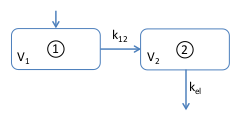

This system can be modeled by the following set of coupled first order differential equations:

\begin{equation}
\begin{bmatrix} \mu_{1}' \\\\ \mu_{2}' \end{bmatrix} = \begin{bmatrix}  -k_{12} & 0 \\\\ \frac{k_{12}V_{1}}{V_{2}} & -k_{el}\end{bmatrix} \begin{bmatrix} \mu_{1} \\\\ \mu_{2}\end{bmatrix}
\end{equation}

In [1]:
# import necessary libraries and functions 
import numpy as np
from numpy.linalg import inv, det
import matplotlib.pyplot as plt
import sympy
from sympy import *
import FIM_PK
from FIM_PK import PK_N_compartment

k_12, k_el, V1, V2 = symbols(('k_12', 'k_el', 'V1', 'V2'), positive=True, real=True)

# time dependent mass balance equations
# (dC1/dt) = -k12*C1
# (dC2/dt) = k12*V1/V2*C1 - kel*C2

# define coefficient matrix a
a  = Matrix([[-k_12, 0],
             [k_12*V1/V2, -k_el]])
# no forcing function
f = Matrix([0,0])

# define params used in model
params = (k_12, k_el, V1, V2)

# create my PK object
PK = PK_N_compartment(a, f, params)

# set maximum likelihood estimate for parameter values 
mle_vals = np.array([.2, .1, 1, 12]) # V1, V2, k12, kel 
PK.set_mle(mle_vals) 

# set initial concentrations 
c0 = np.array([.5, 0]) # compartment 1, compartment 2
PK.set_c0(c0)

Now that a PK object is instantiated with symbolic expressions for the "A" matrix and forcing function, we can evaluate E-optimality of the FIM at different time frames and plot the results.

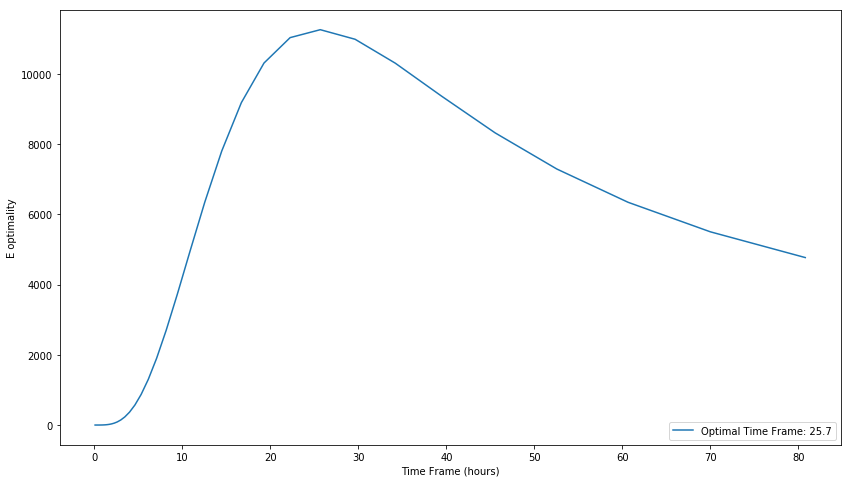

In [2]:
# determine optimal timescale to sample data
days = 3
time = np.linspace(0, days*24, 1000)
N_experiments = 50
scales = np.logspace(-3, .05, N_experiments)
tspan = [max(time)*scale for scale in scales]
E_optimality = np.zeros(N_experiments)

for i, scale in enumerate(scales):
    t_array = time*scale
    FIM = Matrix(PK.FIM(t_array)[:2,:2])
    eig, V = np.linalg.eig(np.array(FIM).astype(np.float))
    E_optimality[i] = min(eig)

best_time_scale = max(time*scales[np.argmax(E_optimality)])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(tspan, E_optimality, label='Optimal Time Frame: {:.1f}'.format(best_time_scale))
ax.set_ylabel('E optimality')
ax.set_xlabel('Time Frame (hours)')
ax.legend(loc='lower right')

plt.show()

### <center> Confirm Results with Parameter Estimation on Simulated Data 
    
The above results suggest that the optimal time frame for collecting a fixed number of samples to best constrain parameter estimates of our PBPK model is 25.7 hours. 

We can confirm these results by performing parameter estimation with simulated experimental data collected over different hypothetical time frames. If our results are correct, estimated parameters from data collected within a 25.7 hour time frame should exhibit the least amount of variability. 

In [4]:
# import optimization functions for parameter estimation
from scipy.optimize import curve_fit, leastsq, fmin
from scipy.integrate import odeint

# define system of equations
def system(C, t, k12, kel):
    c1, c2 = C
    dc1dt = -k12*c1
    dc2dt = k12*1/12*c1 - kel*c2
    return (dc1dt, dc2dt)

# define function to generate simulated "true" data with noise
def get_true_data(system, true_params, c0, tspan, noise=0):
    # generate true data (just second compartment) with noise
    soln = odeint(system, c0, tspan, args=true_params)
    # add noise to soln
    soln += noise*np.random.randn(soln.shape[0], soln.shape[1])
    return soln

# define objective function for parameter estimation from true data
def objective(params, tspan, ydata):
    k_12, k_el = params
    # using numerical solution
    ymodel = odeint(system, c0, tspan, args=(k_12, k_el))
    # return sum of squares error
    return np.sum((ydata - ymodel)**2)

# estimate parameters using Scipy's fmin

# initial parameter guess
param_guess = np.array([.15, .15])
# true params (for generating simulated experimental data)
true_params = (.2, .1)

# number of trials for each hypothetical experiment with fixed number of samples
N_trials = 50
N_samples = 50
t_experiments = np.linspace(1, days*24, N_experiments)
E_optimality_sim = np.zeros(N_experiments)

for i, t_end in enumerate(t_experiments):
    tspan = np.linspace(0, t_end, N_samples)        # time span over which to collect samples

    p1 = np.zeros(N_trials); p2 = np.zeros(N_trials)
    for j in range(N_trials):
        # noise = E (used to calculate FIM) / N_FIM_samples
        Ytrue = get_true_data(system, true_params, c0, tspan, noise=0.001)
        param_opt = fmin(objective, param_guess, args=(tspan, Ytrue), disp=0)
        p1[j], p2[j] = param_opt

    # calculate covariance matrix and E optimality of parameter estimates
    P = np.stack((p1,p2), axis=0)
    FIM = np.linalg.inv(np.cov(P))/N_samples
    eigs, V = np.linalg.eig(FIM)
    E_optimality_sim[i] = min(eigs)

Plot E optimality of FIM results and simulated results 

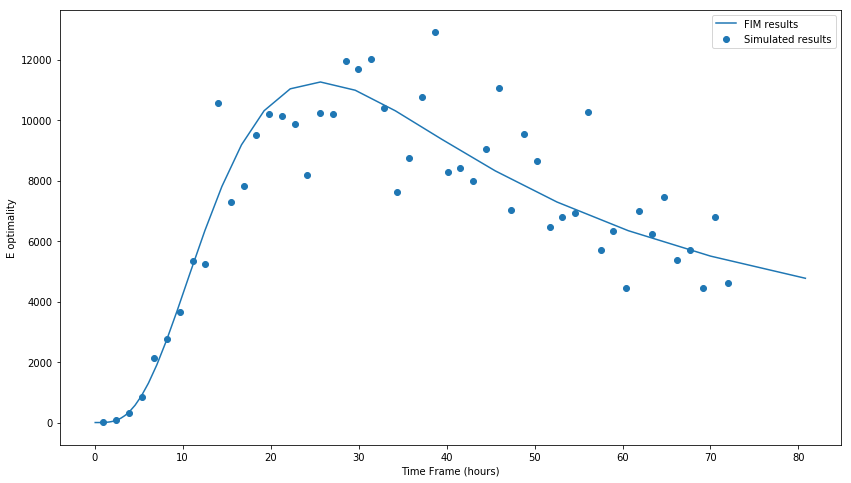

In [6]:
tspan = [max(time)*scale for scale in scales]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(tspan, E_optimality, label='FIM results')
ax.scatter(t_experiments, E_optimality_sim, label='Simulated results')
ax.set_xlabel('Time Frame (hours)')
ax.set_ylabel('E optimality')

ax.legend()
plt.show()

Simulated experimental results show that the covariance of parameter estimates is minimized at the same time frame determined using the above FIM analysis. Future PBPK studies could benefit from optimized experiments designed to minimize variance in parameter estimates. 

### <center> FIM_PK.py 

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sympy
from sympy import *

class PK_N_compartment:

    def __init__(self, a, f, params):
        # set up PK object with a matrix, f forcing function, and parameters

        # determine number of compartments and number of parameters
        self.NC = a.shape[0]
        self.NP = len(params)
        self.order = self.NC*(self.NP + 1)
        self.params = params

        # define symbolic derivatives of a matrix with respect to each param
        ai = {}
        for i, param in enumerate(params):
            ai[i] = diff(a, param)

        # create symoblic matrix A
        A = Matrix(np.zeros([self.order, self.order]))

        for i in range(self.NP+1):
            A[i*self.NC:i*self.NC+self.NC,i*self.NC:i*self.NC+self.NC] = a

        for i in range(1,self.NP+1):
            A[i*self.NC:i*self.NC+self.NC,:self.NC] = ai[i-1]

        # define symbolic forcing function f
        F = Matrix(np.zeros(self.order))

        # populate F with given entries for model forcing function
        for i in range(self.NC):
            F[i] = f[i]

        for i,p in zip(np.arange(self.NC, self.order, self.NC), range(self.NP)):
            for j in range(self.NC):
                F[i+j] = diff(f, params[p])[j]

        self.A = A
        self.F = F

    def set_mle(self, mle_vals):
        # introduce maximum likelihood estimate parameter values to model
        A = self.A
        F = self.F

        subs = {param:mle_val for param,mle_val in zip(self.params, mle_vals)}
        A = A.evalf(subs=subs)
        F = F.evalf(subs=subs)
        A = np.array(A)
        F = np.array(F)
        # not sure why I can't do this in one step..
        self.A = np.array(A, np.float)
        self.F = np.array(F, np.float)

    def set_c0(self, c0):
        self.c0 = np.zeros(self.order)
        self.c0[:self.NC] = c0

    def get_eqn(self):
        return self.A, self.F

    def equations(self, c, t):
        return np.dot(self.A, c) + np.hstack(self.F)

    def solve(self, t_array):
        self.soln = odeint(self.equations, self.c0, t_array)
        return self.soln

    def plot(self, t_array, compartments=False, show=True, label= None, title=None):

        if not compartments:
            compartments = range(self.NC)

        for C in compartments:
            plt.plot(t_array, self.soln[:,C-1], label=label)
        plt.xlabel('time')
        plt.ylabel('concentration')
        if title:
            plt.title(title)
        else:
            plt.title('Concentration in Compartment {}'.format(compartments))
        plt.legend()
        if show:
            plt.show()
        else:
            return plt

    def FIM(self, t_array):
        self.t_array = t_array
        self.NS = len(t_array)
        self.solve(t_array)
        NC = self.NC
        # eqn 14.7: SVi = (dy(t1)/dpi,...,dy(tn)/dpi)'
        # eqn 14.8: SM = (SV1,...,SVl)
        SM = self.soln[:, NC:]
        # define covariance matrix of measurement noise
        E = np.eye(self.NS)
        # eqn 14.20: FIM(0)ij = E(SVi).T * CM^-1 * E(SVj)
        FIM = np.zeros([self.NP, self.NP])
        for i in np.arange(0, self.NP*NC, NC):
            for j in np.arange(0, self.NP*NC, NC):
                for k in range(NC):
                    FIM[i//NC,j//NC] += np.dot(np.dot(SM[:,i+k].T, E), SM[:,j+k])
        FIM*=self.NS 

        return FIM
